# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

#### First feature only

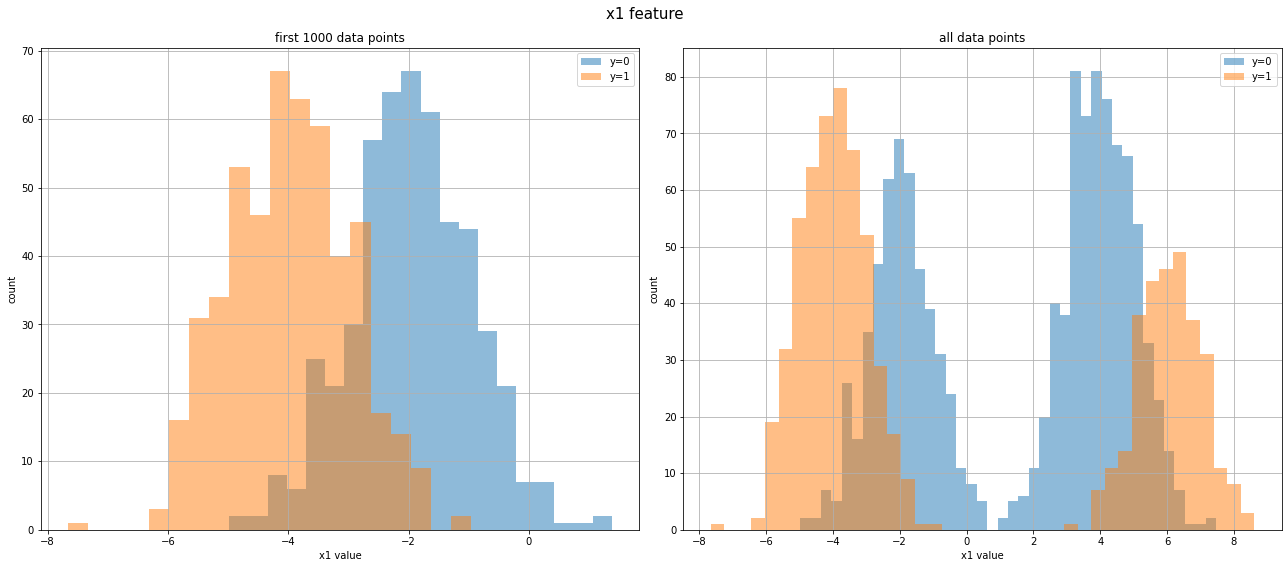

In [4]:
first_1000_points_x1 = training_set.iloc[:1000, [0,-1]]
all_data_points_x1 = training_set.iloc[:, [0, -1]]

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

first_1000_points_x1.groupby('y').x1.hist(ax=axes[0], bins=20, alpha=0.5)
axes[0].set_title('first 1000 data points')
axes[0].set_xlabel('x1 value')
axes[0].set_ylabel('count')
axes[0].legend(['y=0', 'y=1'])

all_data_points_x1.groupby('y').x1.hist(ax=axes[1], bins=40, alpha=0.5)
axes[1].set_title('all data points')
axes[1].set_xlabel('x1 value')
axes[1].set_ylabel('count')
axes[1].legend(['y=0', 'y=1'])

fig.suptitle('x1 feature', fontsize=15)
fig.tight_layout()


#### Both features

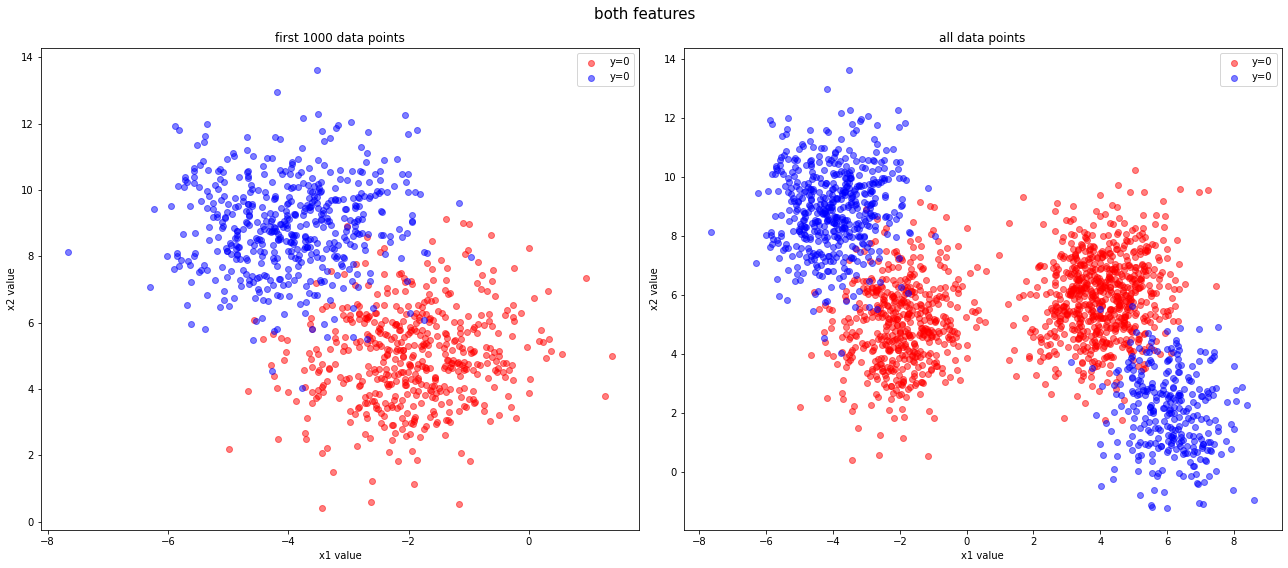

In [5]:
first_1000_points = training_set.iloc[:1000, :]
all_data_points = training_set.iloc[:, :]

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

axes[0].scatter(data=first_1000_points[first_1000_points['y'] == 0], x='x1', y='x2', color='red', label='y=0', alpha=0.5)
axes[0].scatter(data=first_1000_points[first_1000_points['y'] == 1], x='x1', y='x2', color='blue', label='y=0', alpha=0.5)
axes[0].set_title('first 1000 data points')
axes[0].set_xlabel('x1 value')
axes[0].set_ylabel('x2 value')
axes[0].legend()

axes[1].scatter(data=all_data_points[all_data_points['y'] == 0], x='x1', y='x2', color='red', label='y=0', alpha=0.5)
axes[1].scatter(data=all_data_points[all_data_points['y'] == 1], x='x1', y='x2', color='blue', label='y=0', alpha=0.5)
axes[1].set_title('all data points')
axes[1].set_xlabel('x1 value')
axes[1].set_ylabel('x2 value')
axes[1].legend()

fig.suptitle('both features', fontsize=15)
fig.tight_layout()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [6]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.costs_list = []
        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.theta = None

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        # initialize random seed
        np.random.seed(self.random_state)

        # first need to add the bias trick
        X = np.column_stack((np.ones(X.shape[0]), X))

        # initialze theta value for each feature
        theta = np.random.random(X.shape[1])

        for epoch in range(self.n_iter):

          h_0 = self.sigmoid(X @ theta)
          theta -= (self.eta) * ((h_0 - y) @ X)
          self.costs_list.append(self.comupte_cost(h_0, y))

          # check if costs diff is less than eps
          if epoch > 0:
            if np.abs(self.costs_list[epoch] - self.costs_list[epoch-1]) < self.eps:
              break
          
        self.theta = theta


    def predict(self, X):
        """Return the predicted class label"""
        X = np.column_stack((np.ones(X.shape[0]), X))
        theta = self.sigmoid(X @ self.theta)
        return np.round(theta)
    
    @staticmethod
    def comupte_cost(h_x, y):
      return (1 / y.shape[0]) * (-y @ np.log(h_x) - (1 - y) @ np.log(1 - h_x))


## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [7]:
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
n_folds = 5

# shuffeling the data
np.random.seed(45)
shuffled_training = np.arange(X_training.shape[0])
np.random.shuffle(shuffled_training)

# creating the folded data
X_training_shuffled = X_training[shuffled_training]; y_training_shuffled = y_training[shuffled_training]
X_training_splitted = np.split(X_training_shuffled, n_folds); y_training_splitted = np.split(y_training_shuffled, n_folds)
results = pd.DataFrame(index=etas, columns=epss)

for eta in etas:
    for eps in epss:

        accuracy_list = []

        for fold in range(n_folds):
            
            # split data to train and test for X
            x_train_folds = X_training_splitted.copy()
            x_test_folds = X_training_splitted[fold]
            del x_train_folds[fold]  # use the current node as test data
            x_train_folds = np.concatenate(x_train_folds)

            # split data to train and test for y
            y_train_folds = y_training_splitted.copy()
            y_test_folds = y_training_splitted[fold]
            del y_train_folds[fold]  # use the current node as test data
            y_train_folds = np.concatenate(y_train_folds)

            # create instance of LR model
            model = LogisticRegressionGD(eta=eta, eps=eps)
            model.fit(x_train_folds, y_train_folds)

            # calculate predictions
            predicitions = model.predict(x_test_folds)
            accuracy_list.append((predicitions == y_test_folds).sum() / y_test_folds.shape[0] * 100)
        
        results.loc[eta, eps] = np.array(accuracy_list).mean()

accuracy_data = results.stack()[results.stack() == results.max().max()]
best_eta = accuracy_data.index[0][0]
best_eps = accuracy_data.index[0][1]
print(f"{results.max().max()}% is the best accuracy which achieved with eta={best_eta} and eps={best_eps}")

results

79.3% is the best accuracy which achieved with eta=5e-05 and eps=1e-06


,0.010000,0.001000,0.000100,0.000010,0.000001
0.050000,52.4,52.4,52.4,52.4,52.4
0.005000,62.3,62.3,62.3,62.3,62.3
0.000500,57.55,59.9,59.9,59.9,59.9
0.000050,52.2,56.45,57.0,69.65,79.3
0.000005,40.05,49.2,54.3,56.85,69.6


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma}^2)}
$$
Write an efficient vectorized code

In [8]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-(data-mu) ** 2) / (2 * (sigma ** 2)))

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [9]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = 45
        self.resp = None
        self.w = None
        self.mu = None
        self.sigma = None

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        self.w = np.ones(self.k) / self.k
        self.mu = np.array([data.mean() / i for i in range(1, self.k+1)])
        self.sigma = np.array([data.std() / i for i in range(1, self.k+1)])
        
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        try:
          likelihood = np.multiply(np.hstack(norm_pdf(data, self.mu[i], self.sigma[i])[:, None] \
                                              for i in range(self.k)), self.w)
        except ValueError:
          likelihood = np.multiply(np.hstack(norm_pdf(data, self.mu[i], self.sigma[i])[:, None] \
                                                for i in range(self.k)).swapaxes(2, 1), self.w).swapaxes(2, 1)
        
        return likelihood / likelihood.sum(axis=1)[:, None], likelihood

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        new_w = np.mean(self.resp, axis=0)

        new_mu = np.mean(np.multiply(self.resp, np.array(data)[:, None]), axis=0) / new_w

        new_sig = np.sqrt(np.mean(np.multiply(self.resp, np.power(np.array(data)[:, None] - new_mu, 2)), axis=0) / new_w)
        
        return new_w, new_mu, new_sig

    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        prev_log_like = -np.inf
        calc_error = lambda x: -1 * np.sum(np.log(x.sum(axis=1)))

        for _ in range(self.n_iter):

          self.resp, likelihood = self.expectation(data)

          cur_log_like = calc_error(likelihood)

          if np.abs(cur_log_like - prev_log_like) < self.eps:
            break

          prev_log_like = cur_log_like

          self.w, self.mu, self.sigma = self.maximization(data)

    def get_dist_params(self):
        return self.mu, self.sigma, self.w
    

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [10]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k
        self.random_state = 45
        self.models_dict = {}

    def prior(self, y):
      """
      Get the prior probabilities from the training set
      """
      prior_0 = ((y == 0).sum()) / y.shape[0]
      prior_1 = 1 - prior_0
      return prior_0, prior_1

    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        # get prior of the classes
        self.class_0_prior, self.class_1_prior = self.prior(y)

        # now train the data for each class and each feature
        for feature in range(X.shape[1]):
          for class_val in np.unique(y_training):

            feature_data = X[y==class_val, feature]
            model = EM(k=self.k)
            model.fit(feature_data)
            self.models_dict[(feature, class_val)] = model

    
    def predict(self, X):
        """Return the predicted class label"""
        # calculate likelihoods
        likelihoods_dict = {0: [], 1: []}
        for key, value in self.models_dict.items():
            likelihoods_dict[key[1]].append(np.max( \
                value.expectation(X[:, key[0]])[1], axis=1))
        
        # copy prior values
        posterior_0 = self.class_0_prior.copy()
        posterior_1 = self.class_1_prior.copy()

        # calculate posterior using the prior an likelihood
        for feature in range(X.shape[1]):
            posterior_0 *= likelihoods_dict[0][feature]
            posterior_1 *= likelihoods_dict[1][feature]

        # create predictions array
        predicitions = np.zeros(posterior_0.shape)
        predicitions[posterior_0 < posterior_1] = 1
        
        return predicitions

## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

Logistic Regression Model Accuracy -> 93.8%
Naive Bayes Model Accuracy -> 94.2%


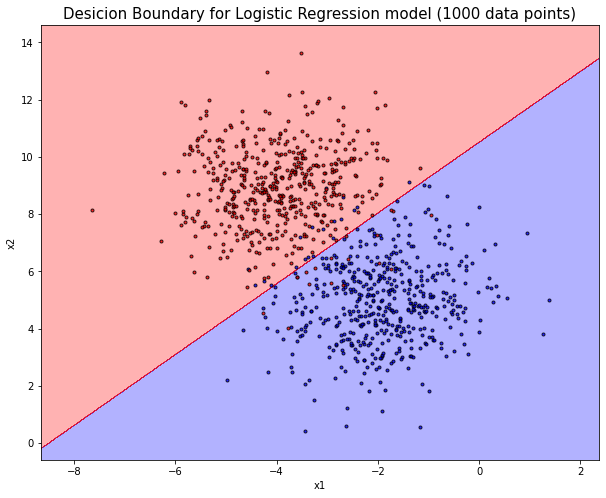

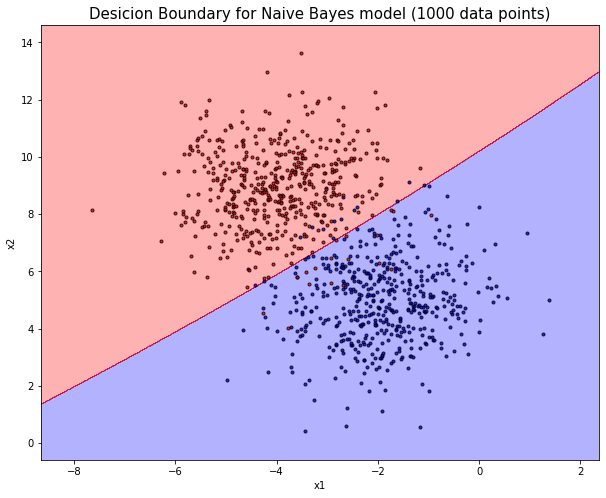

Text(0, 0.5, 'error value')

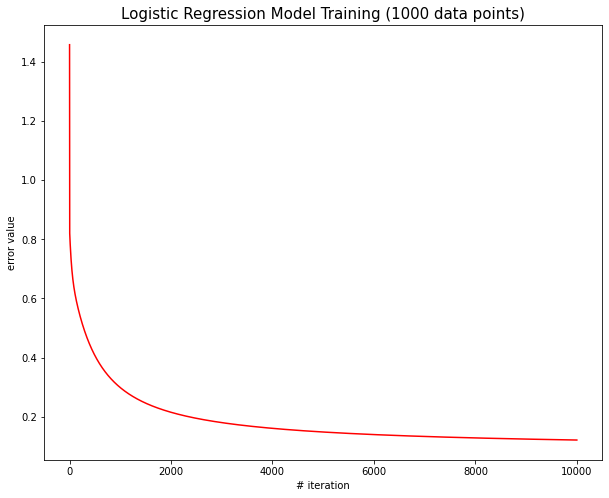

In [11]:
# prepare the subsets of the data
X_training_1000 = X_training[:1000, :]
X_test_500 = X_test[:500, :]
y_training_1000 = y_training[:1000]
y_test_500 = y_test[:500]

# logistic regression model
logistic_regression_model = LogisticRegressionGD(eta=best_eta, eps=best_eps)
logistic_regression_model.fit(X_training_1000, y_training_1000)
logistic_regression_predictions = logistic_regression_model.predict(X_test_500)
logistic_regression_accuracy = ((logistic_regression_predictions == y_test_500).sum() / y_test_500.shape[0]) * 100

# naive bayes model
naive_bayes_model = NaiveBayesGaussian()
naive_bayes_model.fit(X_training_1000, y_training_1000)
naive_bayes_predictions = naive_bayes_model.predict(X_test_500)
naive_bayes_accuracy = (naive_bayes_predictions == y_test_500).sum() / (y_test_500.shape[0]) * 100

# print accuracies
print(f"Logistic Regression Model Accuracy -> {logistic_regression_accuracy}%\nNaive Bayes Model Accuracy -> {naive_bayes_accuracy:.1f}%")

# plot decision boundaries for both models
plot_decision_regions(X_training_1000, y_training_1000, logistic_regression_model)
plt.title('Desicion Boundary for Logistic Regression model (1000 data points)', fontsize=15)
plt.xlabel('x1', fontsize=10)
plt.ylabel('x2', fontsize=10)
plt.show()

plot_decision_regions(X_training_1000, y_training_1000, naive_bayes_model)
plt.title('Desicion Boundary for Naive Bayes model (1000 data points)', fontsize=15)
plt.xlabel('x1', fontsize=10)
plt.ylabel('x2', fontsize=10)
plt.show()

# plot training steps for Logistic Regression model
plt.plot(logistic_regression_model.costs_list, color='red')
plt.title('Logistic Regression Model Training (1000 data points)', fontsize=15)
plt.xlabel('# iteration', fontsize=10)
plt.ylabel('error value', fontsize=10)

Logistic Regression Model Accuracy -> 80.4%
Naive Bayes Model Accuracy -> 90.4%


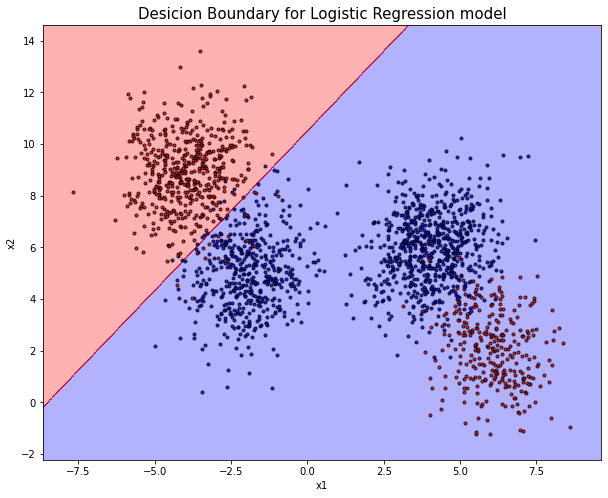

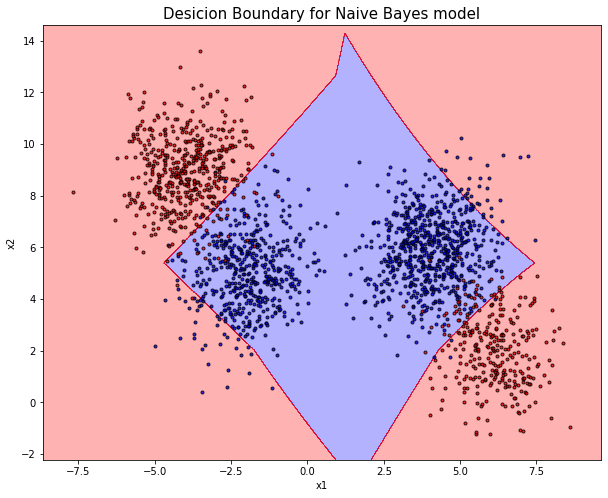

Text(0, 0.5, 'error value')

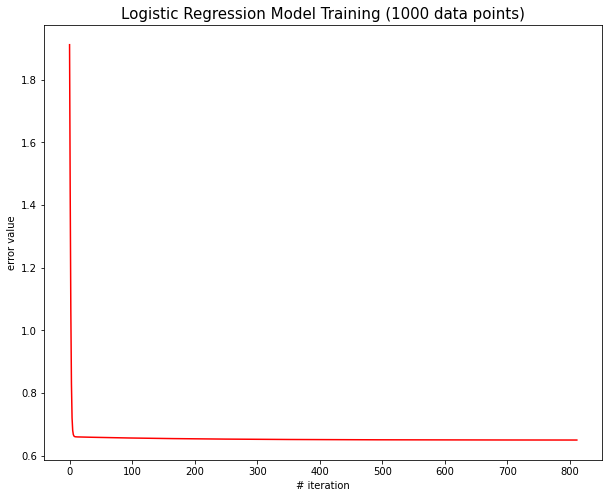

In [12]:
# logistic regression model
logistic_regression_model_full = LogisticRegressionGD(eta=best_eta, eps=best_eps)
logistic_regression_model_full.fit(X_training, y_training)
logistic_regression_predictions = logistic_regression_model_full.predict(X_test)
logistic_regression_accuracy = ((logistic_regression_predictions == y_test).sum() / y_test.shape[0]) * 100

# naive bayes model
naive_bayes_model_full = NaiveBayesGaussian(k=2)
naive_bayes_model_full.fit(X_training, y_training)
naive_bayes_predictions = naive_bayes_model_full.predict(X_test)
naive_bayes_accuracy = (naive_bayes_predictions == y_test).sum() / (y_test.shape[0]) * 100

# print accuracies
print(f"Logistic Regression Model Accuracy -> {logistic_regression_accuracy}%\nNaive Bayes Model Accuracy -> {naive_bayes_accuracy:.1f}%")

# plot desiciion boundaries for both models
plot_decision_regions(X_training, y_training, logistic_regression_model)
plt.title('Desicion Boundary for Logistic Regression model', fontsize=15)
plt.xlabel('x1', fontsize=10)
plt.ylabel('x2', fontsize=10)
plt.show()

plot_decision_regions(X_training, y_training, naive_bayes_model_full)
plt.title('Desicion Boundary for Naive Bayes model', fontsize=15)
plt.xlabel('x1', fontsize=10)
plt.ylabel('x2', fontsize=10)
plt.show()

# plot training steps for Logistic Regression model
plt.plot(logistic_regression_model_full.costs_list, color='red')
plt.title('Logistic Regression Model Training (1000 data points)', fontsize=15)
plt.xlabel('# iteration', fontsize=10)
plt.ylabel('error value', fontsize=10)

### <ins>Explainations</ins>

#### <ins>1000 data points:</ins>

As seen in the data visualization part of the execrise, the first 1000 data points are not perfectly linearly seperable but the 2 classes could be distinguished quite easliy. Hence, applying logistic regression and naive bayes models should achieve good accuracy of seperating the two classes.<br>Therefore, the accuracy of LR model (93.8%) and NB model (94.2%) are high as expected. Since the data is not linearly seperable the accuracy in both models could not be 100%.

#### <ins>All data points:</ins>

On the contrary, by using all of the data points it seems that there are 2 gaussian distributions. Therefore, we expect the logistic regression to fail, and the naive bayes model to succeed after adjusting the number of GMMs to 2 instead of 1 as before.<br>As expected we could see that the accuracy of the Logistic Regression model is 80.4% which is not drastically low, but the desicion boundary plot of the LR model displays a bad seperation of the data which confirms our expectations. On the other hand, we could see that after the modification of the number of GMMs, the accuracy of the naive bayes is quite high (90.4%) and in the graph we could see a good seperation of the data.<br>Moreover, we could observe a fast convergence of the LR model in less than 50 steps while running the model on the 1000 data points achived convergence only after 8000 steps.

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Naive Bayes will work better than Logisitc Regression**.
   2. Generate another dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Logistic Regression will work better than Naive Bayes**.
   
   - Explain the reasoning behind each dataset.  

2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

#### Your code and explanations here ####


In [13]:
def preprocess(data: np.array):

    # shuffeling the data
    np.random.seed(45)
    shuffled_idx = np.arange(data.shape[0])
    np.random.shuffle(data)
    data = data[shuffled_idx]
    
    # training and validation split
    indices = np.random.permutation(data.shape[0])
    idx_train, idx_test = indices[: int(0.8 * data.shape[0])], indices[int(0.8 * data.shape[0]): ]
    x_train, x_test = data[:, :-1][idx_train], data[:, :-1][idx_test]
    y_train, y_test = data[:, -1][idx_train], data[:, -1][idx_test]
    
    return x_train, x_test, y_train, y_test

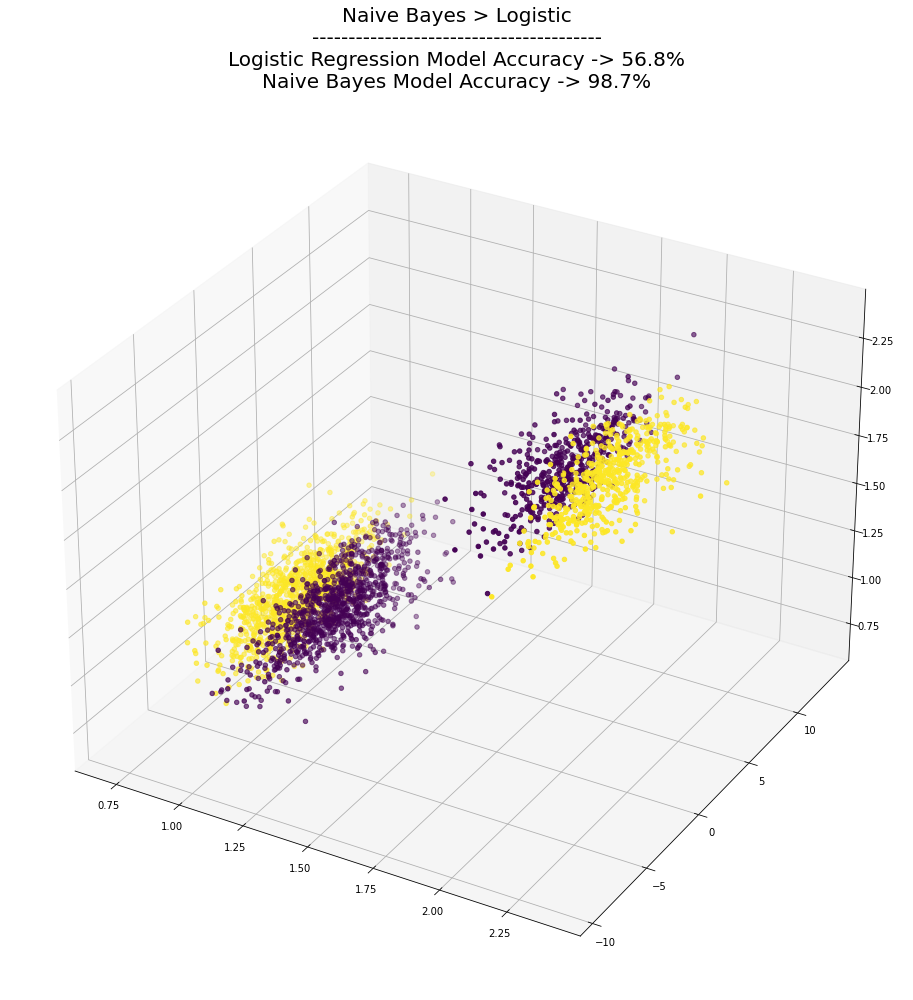

In [37]:
from scipy.stats import multivariate_normal

# create the data
num_samples = 1000
data_dict_nb = {}

for idx, mean in enumerate([2, 1, 1]):
    X, Y, Z = multivariate_normal.rvs(mean=mean, cov=0.01, size=num_samples),\
              multivariate_normal.rvs(mean=mean, cov=10, size=num_samples), \
              multivariate_normal.rvs(mean=mean, cov=0.01, size=num_samples)
    
    data_dict_nb[idx] = np.column_stack((X, Y, Z))

nb_data = np.vstack([sub_data for sub_data in data_dict_nb.values()])
nb_data = np.column_stack((nb_data, np.zeros(3000)))
nb_data[:, -1][np.where((nb_data[:, 0] > 2.0) | (nb_data[:, 0] < 1.0))] = 1

# preprocessing the data and estimating the models' performances
nb_x_train, nb_x_test, nb_y_train, nb_y_test = preprocess(nb_data)

logistic_regression_model_nb = LogisticRegressionGD(eta=best_eta, eps=best_eps)
logistic_regression_model_nb.fit(nb_x_train, nb_y_train)
LR_accuracy_nb = ((logistic_regression_model_nb.predict(nb_x_test) == nb_y_test).sum() / nb_y_test.shape[0]) * 100

naive_bayes_model_nb = NaiveBayesGaussian(k=3)
naive_bayes_model_nb.fit(nb_x_train, nb_y_train)
NB_accuracy_nb = ((naive_bayes_model_nb.predict(nb_x_test) == nb_y_test).sum() / nb_y_test.shape[0]) * 100

# visualizing the report
fig = plt.figure(figsize=(18, 14))
ax = plt.axes(projection='3d')
ax.scatter3D(nb_data[:, 0], nb_data[:, 1], nb_data[:, 2], c=(nb_data[:, -1] == 1), cmap='viridis')
ax.set_title(f"Naive Bayes > Logistic\n{'-'*40}\nLogistic Regression Model Accuracy ->\
 {LR_accuracy_nb:.1f}%\nNaive Bayes Model Accuracy -> {NB_accuracy_nb:.1f}%", fontsize=20)
fig.tight_layout()

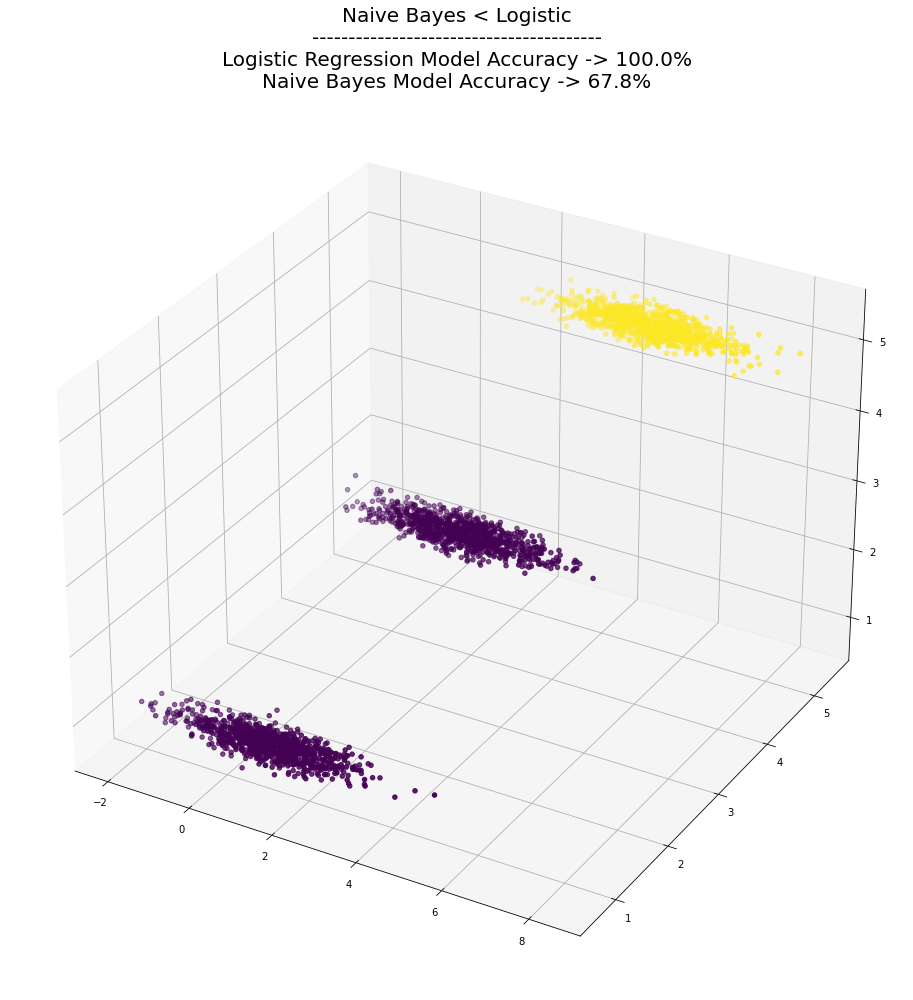

In [31]:
# create the data
num_samples = 1000
data_dict_lr = {}

for idx, mean in enumerate([1, 3, 5]):
    X, Y, Z = multivariate_normal.rvs(mean=mean, cov=1, size=num_samples),\
              multivariate_normal.rvs(mean=mean, cov=0.01, size=num_samples), \
              multivariate_normal.rvs(mean=mean, cov=0.01, size=num_samples)

    data_dict_lr[idx] = np.column_stack((X, Y, Z))
    
lr_data = np.vstack([sub_data for sub_data in data_dict_lr.values()])
lr_data = np.column_stack((lr_data, np.zeros(3000)))
lr_data[:, -1][np.where(lr_data[:, 2] > 4)] = 1

# preprocessing the data and estimating the models' performances
lr_x_train, lr_x_test, lr_y_train, lr_y_test = preprocess(lr_data)

logistic_regression_model_lr = LogisticRegressionGD(eta=best_eta, eps=best_eps)
logistic_regression_model_lr.fit(lr_x_train, lr_y_train)
LR_accuracy_lr = ((logistic_regression_model_lr.predict(lr_x_test) == lr_y_test).sum() / lr_y_test.shape[0]) * 100

naive_bayes_model_lr = NaiveBayesGaussian(k=3)
naive_bayes_model_lr.fit(lr_x_train, lr_y_train)
NB_accuracy_lr = ((naive_bayes_model_lr.predict(lr_x_test) == lr_y_test).sum() / lr_y_test.shape[0]) * 100

# visualizing the report
fig = plt.figure(figsize=(18, 14))
ax = plt.axes(projection='3d')
ax.scatter3D(lr_data[:, 0], lr_data[:, 1], lr_data[:, 2], c=(lr_data[:, -1] == 1), cmap='viridis')
ax.set_title(f"Naive Bayes < Logistic\n{'-'*40}\nLogistic Regression Model Accuracy ->\
 {LR_accuracy_lr:.1f}%\nNaive Bayes Model Accuracy -> {NB_accuracy_lr:.1f}%", fontsize=20)
fig.tight_layout()

## <ins>Explaination</ins>

#### <ins>Logistic > Naive Bayes:</ins>

We created a data that <b>is linearly seperable</b> therefore the Logistic Regression model will successfully output a perfect decision boundary between the 2 classes.<br>On the contrary, since <b>Naive</b> Bayes assumes the features are conditionaly independent given the class which is not the case regarding the data, it will fail to distinguish between them.

#### <ins>Logistic < Naive Bayes:</ins>

we created a data the <b>is not linearly seperable</b>, hence the Logistic Regression model will output a poor decision boundary between the 2 classes. On the other hand, the Naive Bayes algorithm is not affected by the fact that the data is not linearly seperable, and the classification using this algorithm on this data should work quite well.